<a href="https://colab.research.google.com/github/herlinalim-ugm/Machine-Translation/blob/main/NMT_Tanpa_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Jumlah data train: 500, valid: 100, test: 400
Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0012 - loss: 8.2102    
Epoch 1: val_loss improved from inf to 8.20717, saving model to /content/drive/MyDrive/Colab Notebooks/NMT/best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.0017 - loss: 8.2101 - val_accuracy: 0.0196 - val_loss: 8.2072 - learning_rate: 5.0000e-04
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0190 - loss: 8.2071
Epoch 2: val_loss improved from 8.20717 to 8.20279, saving model to /content/drive/MyDrive/Colab Notebooks/NMT/best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.0197 - loss: 8.2070 - val_accuracy: 0.0303 - val_loss: 8.2028 - learning_rate: 5.0000e-04
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0343 - loss: 8.2032
Epoch 3: val_loss improved from 8.20279 to 8.19641, saving model to /content/drive/MyDrive/Colab Notebooks/NMT/best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accur

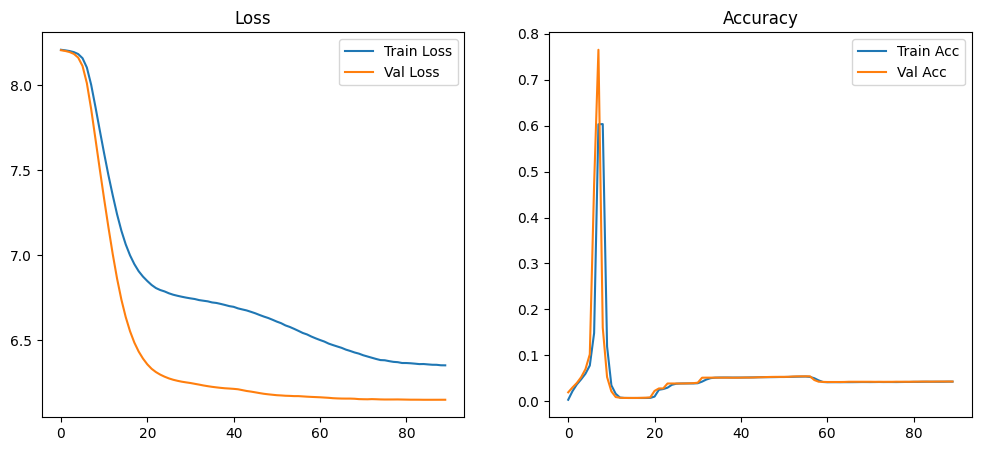

In [2]:
# =========================================
# 🚀 NMT Indonesia → Jawa (RNN Seq2Seq)
# =========================================

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ------------------------------
# 1️⃣ Load Dataset
# ------------------------------
train_path = "/content/drive/MyDrive/Colab Notebooks/NMT/train.csv"
valid_path = "/content/drive/MyDrive/Colab Notebooks/NMT/valid.csv"
test_path  = "/content/drive/MyDrive/Colab Notebooks/NMT/test.csv"

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

print(f"Jumlah data train: {len(train_df)}, valid: {len(valid_df)}, test: {len(test_df)}")

# ------------------------------
# 2️⃣ Persiapan Data
# ------------------------------
input_texts_train = train_df["indonesian"].astype(str).tolist()
target_texts_train = ["<start> " + t + " <end>" for t in train_df["javanese"].astype(str).tolist()]

input_texts_val = valid_df["indonesian"].astype(str).tolist()
target_texts_val = ["<start> " + t + " <end>" for t in valid_df["javanese"].astype(str).tolist()]

input_texts_test = test_df["indonesian"].astype(str).tolist()
target_texts_test = ["<start> " + t + " <end>" for t in test_df["javanese"].astype(str).tolist()]

# Tokenizer
tokenizer_src = Tokenizer(filters='')
tokenizer_src.fit_on_texts(input_texts_train)
tokenizer_tgt = Tokenizer(filters='')
tokenizer_tgt.fit_on_texts(target_texts_train)

input_train = tokenizer_src.texts_to_sequences(input_texts_train)
target_train = tokenizer_tgt.texts_to_sequences(target_texts_train)
input_val = tokenizer_src.texts_to_sequences(input_texts_val)
target_val = tokenizer_tgt.texts_to_sequences(target_texts_val)
input_test = tokenizer_src.texts_to_sequences(input_texts_test)
target_test = tokenizer_tgt.texts_to_sequences(target_texts_test)

max_encoder_seq_length = max([len(txt) for txt in input_train])
max_decoder_seq_length = max([len(txt) for txt in target_train])

encoder_input_train = pad_sequences(input_train, maxlen=max_encoder_seq_length, padding='post')
decoder_input_train = pad_sequences(target_train, maxlen=max_decoder_seq_length, padding='post')
encoder_input_val = pad_sequences(input_val, maxlen=max_encoder_seq_length, padding='post')
decoder_input_val = pad_sequences(target_val, maxlen=max_decoder_seq_length, padding='post')
encoder_input_test = pad_sequences(input_test, maxlen=max_encoder_seq_length, padding='post')
decoder_input_test = pad_sequences(target_test, maxlen=max_decoder_seq_length, padding='post')

num_encoder_tokens = len(tokenizer_src.word_index) + 1
num_decoder_tokens = len(tokenizer_tgt.word_index) + 1

# ------------------------------
# 3️⃣ Hyperparameters
# ------------------------------
embedding_dim = 256
latent_dim = 64
batch_size = 128
epochs = 300
learning_rate = 0.001
dropout_rate = 0.5

# ------------------------------
# 4️⃣ Model Encoder-Decoder
# ------------------------------
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, embedding_dim, mask_zero=True)(encoder_inputs)
enc_emb = Dropout(dropout_rate)(enc_emb)
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_decoder_tokens, embedding_dim, mask_zero=True)(decoder_inputs)
dec_emb = Dropout(dropout_rate)(dec_emb)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# ------------------------------
# 5️⃣ Compile & Training
# ------------------------------
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callback untuk kontrol training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/NMT/best_model.keras',
    monitor='val_loss', save_best_only=True, verbose=1)

# Kompilasi ulang dengan LR lebih kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    [encoder_input_train, decoder_input_train[:, :-1]],
    np.expand_dims(decoder_input_train[:, 1:], -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [encoder_input_val, decoder_input_val[:, :-1]],
        np.expand_dims(decoder_input_val[:, 1:], -1)
    ),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)

# ------------------------------
# 6️⃣ Plot Training & Validation
# ------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    881,664 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │    942,080 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 256) │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     82,176 │ dropout[0][0],    │
│                     │ (None, 64),       │            │ not_equal[0][0]   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │     82,176 │ dropout_1[0][0],  │
│                     │ 64), (None, 64),  │            │ lstm[0][1],       │
│                     │ (None, 64)]       │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │    239,200 │ lstm_1[0][0]      │
│                     │ 3680)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,681,890 (25.49 MB)

 Trainable params: 2,227,296 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,454,594 (16.99 MB)


=== Evaluasi BLEU Score pada Data Test (Subset) ===

Input : Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
Ref   : Cepak saka hotelku nginep, namung digawa mlaku, ing kene akeh tenan pilian panganane, panggonane sing amba, lan nyenengake
Pred  : aku sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing
BLEU  : 0.0023

Input : Iya benar, dia sedang jaga warung.
Ref   : Iya bener, deknen lagi jaga warung.
Pred  : aku aku aku aku aku aku aku aku aku aku aku aku sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sing sin

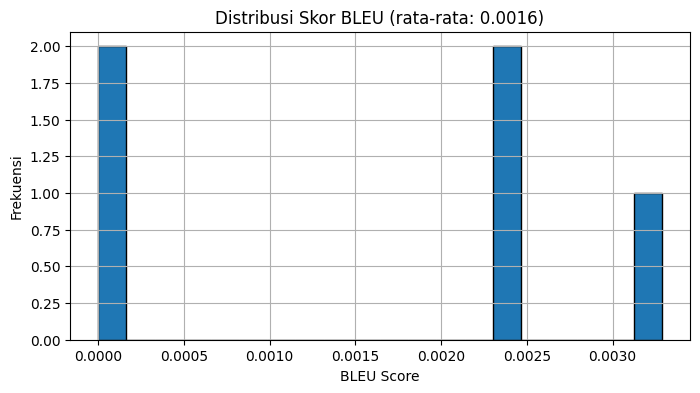

In [4]:
# =========================================
# 7️⃣ Inference Model
# =========================================
# Encoder inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# --- Decoder Embedding ---
decoder_inputs_single = Input(shape=(1,))
dec_emb_layer = Embedding(num_decoder_tokens, embedding_dim, mask_zero=True)

# 🔧 Bangun dulu layer dengan dummy input sebelum set_weights
_ = dec_emb_layer(tf.zeros((1, 1), dtype=tf.int32))
dec_emb_layer.set_weights(model.layers[3].get_weights())
dec_emb_layer.trainable = False

# --- Decoder LSTM ---
decoder_lstm_inf = LSTM(latent_dim, return_sequences=True, return_state=True)
_ = decoder_lstm_inf(tf.zeros((1, 1, embedding_dim)))
decoder_lstm_inf.set_weights(model.layers[6].get_weights())
decoder_lstm_inf.trainable = False

# --- Decoder Dense ---
decoder_dense_inf = Dense(num_decoder_tokens, activation='softmax')
_ = decoder_dense_inf(tf.zeros((1, 1, latent_dim)))
decoder_dense_inf.set_weights(model.layers[-1].get_weights())
decoder_dense_inf.trainable = False

# --- Build decoder model ---
dec_emb_inf = dec_emb_layer(decoder_inputs_single)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_inf(
    dec_emb_inf, initial_state=decoder_states_inputs)
decoder_outputs_inf = decoder_dense_inf(decoder_outputs_inf)
decoder_states_inf = [state_h_inf, state_c_inf]

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

# =========================================
# 8️⃣ Fungsi Decoding
# =========================================
reverse_target_index = {i: word for word, i in tokenizer_tgt.word_index.items()}
reverse_source_index = {i: word for word, i in tokenizer_src.word_index.items()}

def decode_sequence(input_seq):
    # Ambil state dari encoder
    states_value = encoder_model.predict(input_seq, verbose=0)
    # Awali token dengan <start>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_tgt.word_index['<start>']

    decoded_sentence = []
    for _ in range(max_decoder_seq_length):  # batasi panjang output
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_index.get(sampled_token_index, '')
        if sampled_word == '<end>' or sampled_word == '':
            break
        decoded_sentence.append(sampled_word)
        # perbarui target dan state
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return ' '.join(decoded_sentence)

# =========================================
# 9️⃣ Evaluasi BLEU (5 Sampel Saja, Stabil)
# =========================================
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

smooth = SmoothingFunction().method1
bleu_scores = []
num_samples = 5

print("\n=== Evaluasi BLEU Score pada Data Test (Subset) ===")
for i in range(min(num_samples, len(test_df))):
    input_seq = encoder_input_test[i:i+1]
    decoded_sentence = decode_sequence(input_seq)

    reference = test_df['javanese'][i].replace("<start>", "").replace("<end>", "").strip().split()
    candidate = decoded_sentence.split()

    bleu = sentence_bleu([reference], candidate, smoothing_function=smooth)
    bleu_scores.append(bleu)

    # tampilkan 5 contoh pertama
    if i < 5:
        print(f"\nInput : {test_df['indonesian'][i]}")
        print(f"Ref   : {' '.join(reference)}")
        print(f"Pred  : {' '.join(candidate)}")
        print(f"BLEU  : {bleu:.4f}")

# BLEU rata-rata subset
avg_bleu = np.mean(bleu_scores)
print(f"\n=== Rata-rata BLEU (n={len(bleu_scores)}): {avg_bleu:.4f} ===")

# =========================================
# 📊 Distribusi Skor BLEU
# =========================================
plt.figure(figsize=(8,4))
plt.hist(bleu_scores, bins=20, edgecolor='black')
plt.title(f"Distribusi Skor BLEU (rata-rata: {avg_bleu:.4f})")
plt.xlabel("BLEU Score")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()


=== Evaluasi BLEU Score untuk 400 sampel test ===


100%|██████████| 400/400 [1:04:56<00:00,  9.74s/it]


=== Rata-rata BLEU (400 sampel): 0.0012 ===


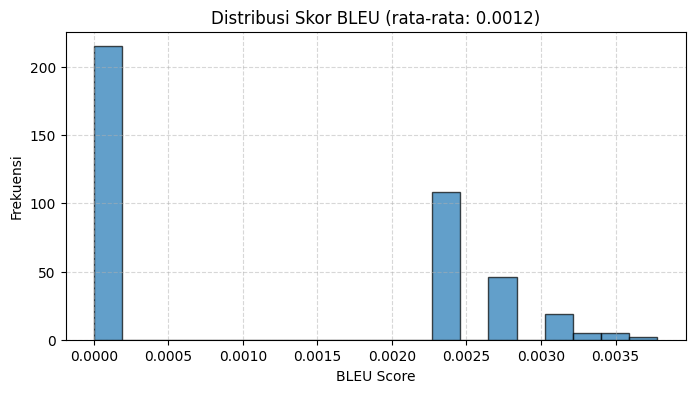

In [6]:
# =========================================
# 🔟 Evaluasi BLEU (Distribusi Seluruh Data Test)
# =========================================
from tqdm import tqdm

smooth = SmoothingFunction().method1
bleu_scores_all = []

num_samples_full = min(400, len(test_df))  # batasi 200 agar cepat
print(f"\n=== Evaluasi BLEU Score untuk {num_samples_full} sampel test ===")

for i in tqdm(range(num_samples_full)):
    input_seq = encoder_input_test[i:i+1]
    decoded_sentence = decode_sequence(input_seq)

    reference = target_texts_test[i].replace("<start>", "").replace("<end>", "").strip().split()
    candidate = decoded_sentence.split()

    if len(candidate) == 0:
        bleu = 0.0
    else:
        bleu = sentence_bleu([reference], candidate, smoothing_function=smooth)
    bleu_scores_all.append(bleu)

# Hitung rata-rata BLEU
avg_bleu_all = np.mean(bleu_scores_all)
print(f"\n=== Rata-rata BLEU ({num_samples_full} sampel): {avg_bleu_all:.4f} ===")

# =========================================
# 📊 Grafik Distribusi BLEU
# =========================================
plt.figure(figsize=(8, 4))
plt.hist(bleu_scores_all, bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Distribusi Skor BLEU (rata-rata: {avg_bleu_all:.4f})")
plt.xlabel("BLEU Score")
plt.ylabel("Frekuensi")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


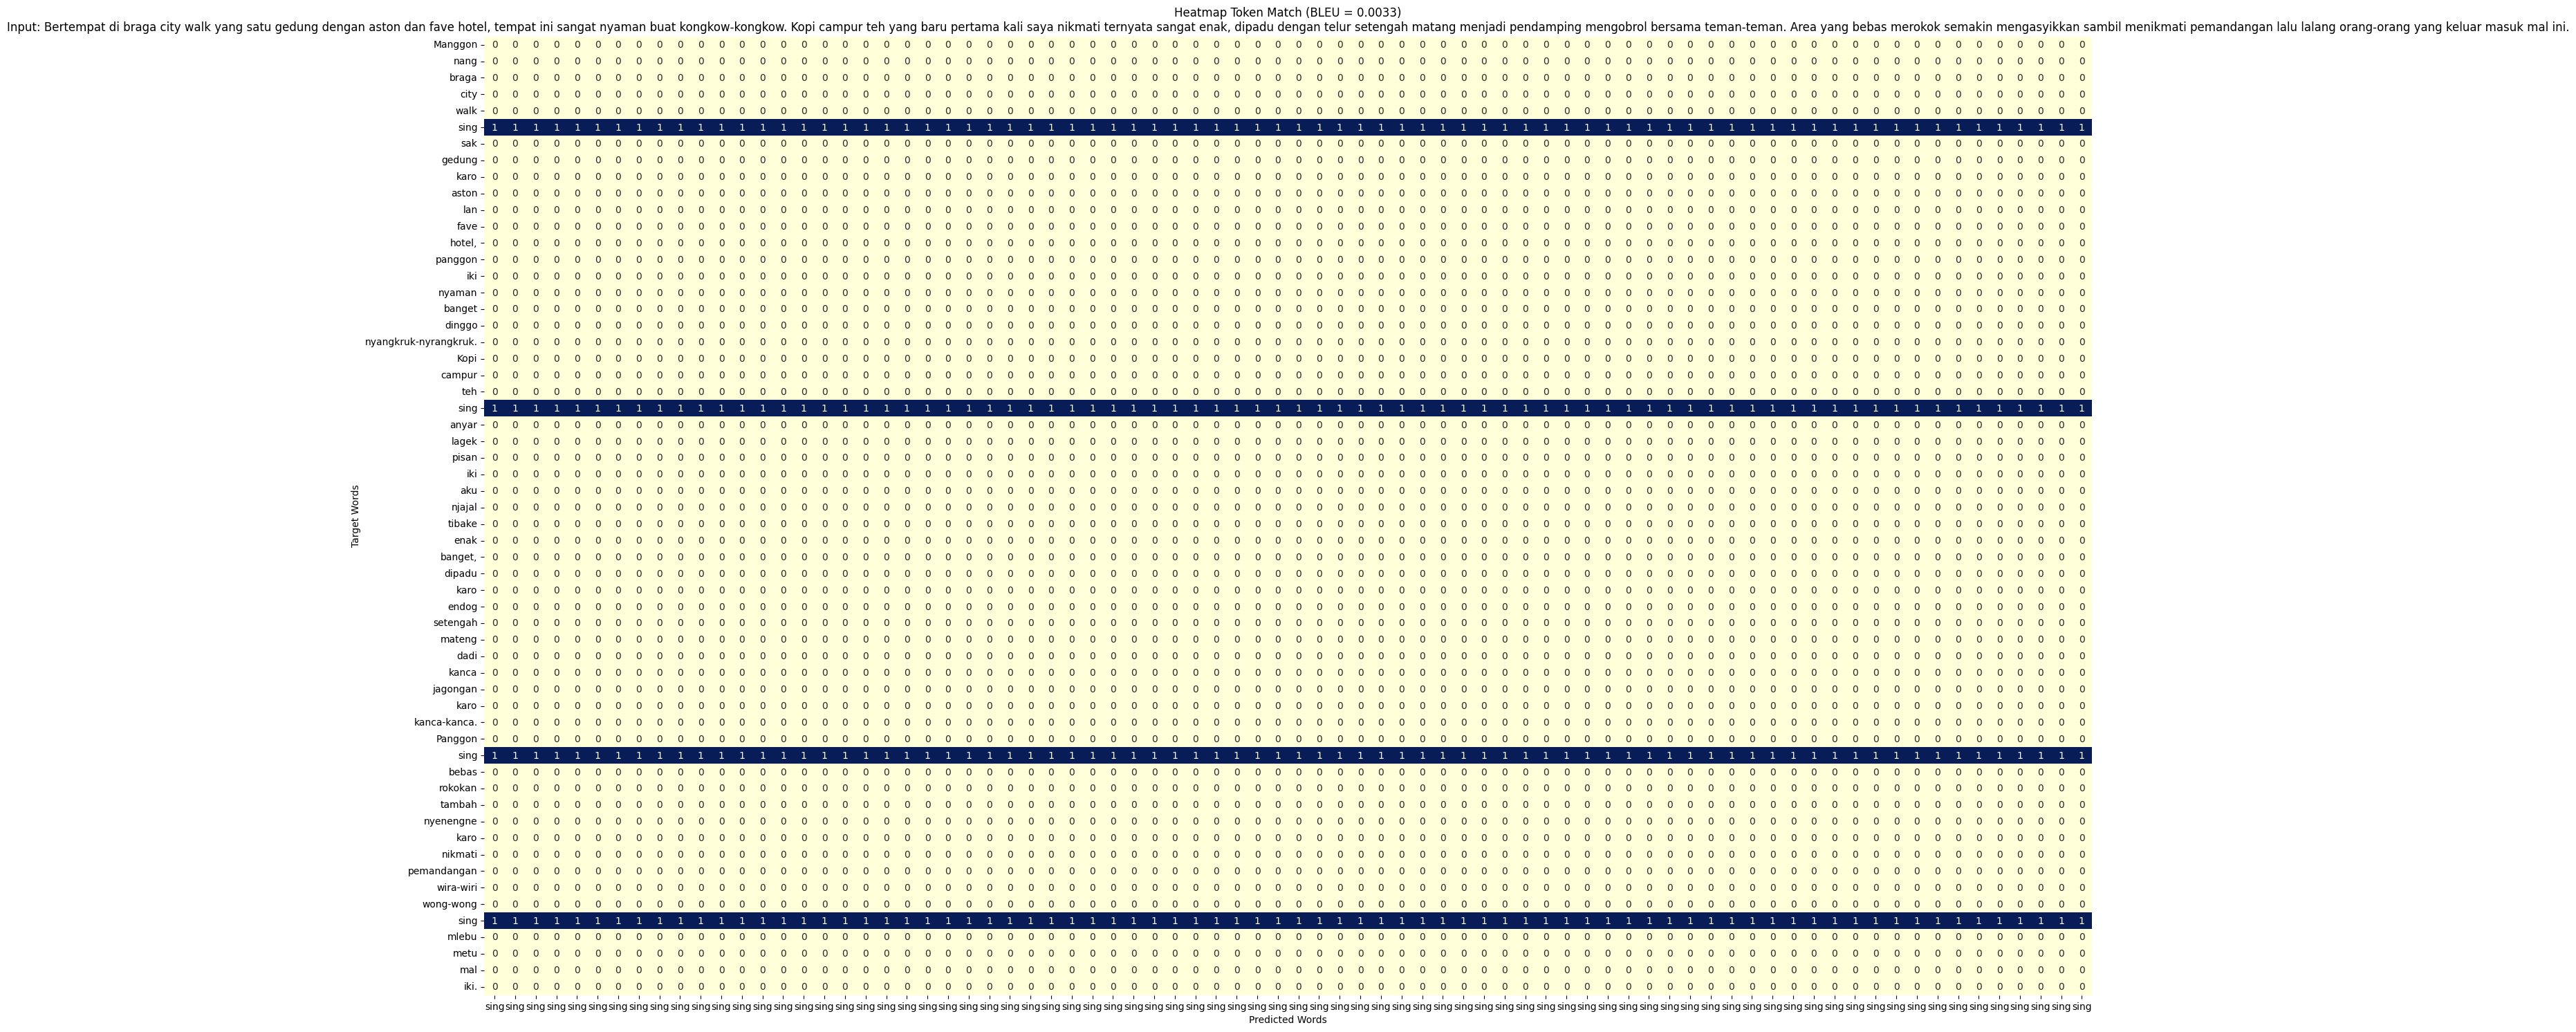

In [7]:
# =========================================
# 🔍 10️⃣ Visualisasi Heatmap untuk Kalimat dengan BLEU Tertinggi
# =========================================
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Cari index kalimat dengan BLEU tertinggi
best_idx = np.argmax(bleu_scores)

# Ambil input, referensi, dan prediksi terbaik
input_seq = encoder_input_test[best_idx:best_idx+1]
best_input = test_df['indonesian'][best_idx]
best_ref = test_df['javanese'][best_idx].replace("<start>", "").replace("<end>", "").strip().split()
best_pred = decode_sequence(input_seq).split()

# Buat matriks kesamaan sederhana (1 jika kata sama, 0 jika tidak)
heatmap_matrix = np.zeros((len(best_ref), len(best_pred)))
for i, ref_word in enumerate(best_ref):
    for j, pred_word in enumerate(best_pred):
        if ref_word == pred_word:
            heatmap_matrix[i, j] = 1

# Plot heatmap
plt.figure(figsize=(30, 18))
sns.heatmap(
    heatmap_matrix,
    annot=True,
    cmap="YlGnBu",
    xticklabels=best_pred,
    yticklabels=best_ref,
    cbar=False
)
plt.title(f"Heatmap Token Match (BLEU = {bleu_scores[best_idx]:.4f})\nInput: {best_input}")
plt.xlabel("Predicted Words")
plt.ylabel("Target Words")
plt.show()

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-1320228598.py:64: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


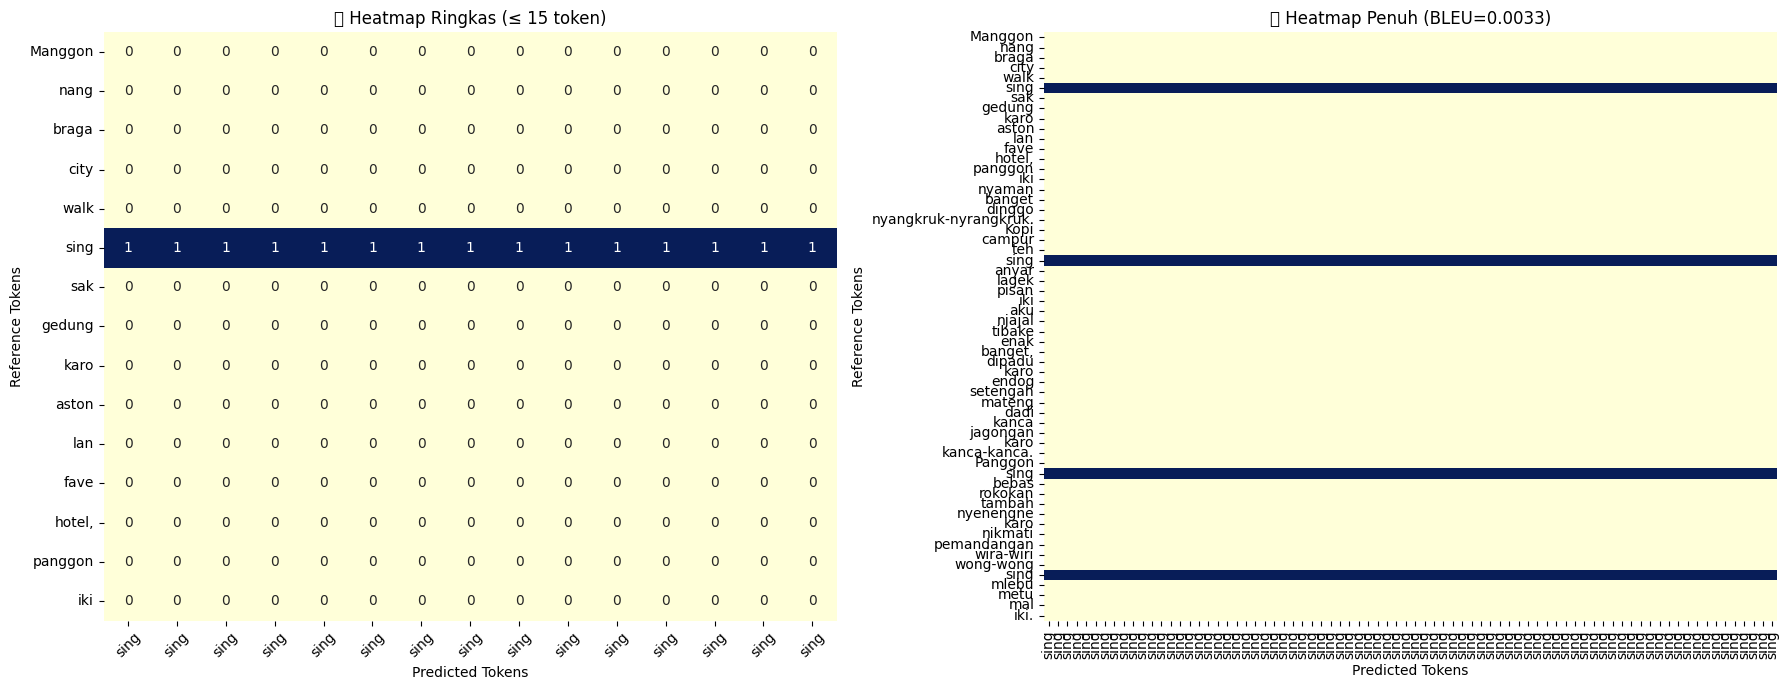

In [8]:
# =========================================
# 🔥 Heatmap Gabungan
# =========================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ambil kalimat target (reference) dan prediksi dengan skor BLEU tertinggi
ref_words = best_ref
pred_words = best_pred

# Fungsi untuk membuat matriks kecocokan sederhana
def make_heatmap_matrix(ref, pred):
    matrix = np.zeros((len(ref), len(pred)))
    for i, r in enumerate(ref):
        for j, p in enumerate(pred):
            if r == p:
                matrix[i, j] = 1
    return matrix

# Matriks penuh dan potongan awal
heatmap_full = make_heatmap_matrix(ref_words, pred_words)
max_tokens_show = 15
ref_cut = ref_words[:max_tokens_show]
pred_cut = pred_words[:max_tokens_show]
heatmap_short = make_heatmap_matrix(ref_cut, pred_cut)

# === Plot 2 subplot berdampingan ===
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Heatmap Ringkas ---
sns.heatmap(
    heatmap_short,
    ax=axes[0],
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    xticklabels=pred_cut,
    yticklabels=ref_cut,
    cbar=False
)
axes[0].set_title(f"🔹 Heatmap Ringkas (≤ {max_tokens_show} token)")
axes[0].set_xlabel("Predicted Tokens")
axes[0].set_ylabel("Reference Tokens")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# --- Heatmap Penuh ---
sns.heatmap(
    heatmap_full,
    ax=axes[1],
    annot=False,
    cmap="YlGnBu",
    xticklabels=pred_words,
    yticklabels=ref_words,
    cbar=False
)
axes[1].set_title(f"🔸 Heatmap Penuh (BLEU={bleu_scores[best_idx]:.4f})")
axes[1].set_xlabel("Predicted Tokens")
axes[1].set_ylabel("Reference Tokens")
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()
